In [1]:
import tensorflow as tf
import os

# Avoid Out of Memory Error by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

gpus

2024-01-21 17:00:06.864761: I tensorflow/core/platform/cpu_feature_guard.cc:183] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE3 SSE4.1 SSE4.2 AVX, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-21 17:00:08.816939: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:1013] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-01-21 17:00:08.829551: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:1013] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L3

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

Load Data

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# Build data pipline
training_data = tf.keras.utils.image_dataset_from_directory('BM_cytomorphology_data', image_size=(250, 250))
val_data = tf.keras.utils.image_dataset_from_directory('Validation', image_size=(250, 250))
data_iterator = training_data.as_numpy_iterator()
batch = data_iterator.next()

label_to_class_mapping = {label: class_name for label, class_name in enumerate(training_data.class_names)}

label_to_class_mapping

numeric_labels = batch[1]

# Convert numeric labels to class names
class_names = [label_to_class_mapping[label] for label in numeric_labels]

Found 95987 files belonging to 21 classes.


2024-01-21 17:00:12.912990: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:1013] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-01-21 17:00:12.913220: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:1013] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-01-21 17:00:12.913386: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:1013] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/s

Found 23973 files belonging to 21 classes.


2024-01-21 17:00:13.996820: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [95987]
	 [[{{node Placeholder/_4}}]]
2024-01-21 17:00:13.997268: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [95987]
	 [[{{node Placeholder/_4}}]]


2. Preprocess Data

2.1 Scale Data

In [3]:
#Scale data from 0-255 to 0-1
training_data = training_data.map(lambda image,label: (image/255, label))
val_data = val_data.map(lambda image,label: (image/255, label))
scaled_iterator = training_data.as_numpy_iterator()
batch = scaled_iterator.next()
batch[0].max()
# data.as_numpy_iterator().next()[0].max()

2024-01-21 17:00:14.198508: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [95987]
	 [[{{node Placeholder/_4}}]]
2024-01-21 17:00:14.198930: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [95987]
	 [[{{node Placeholder/_4}}]]


1.0

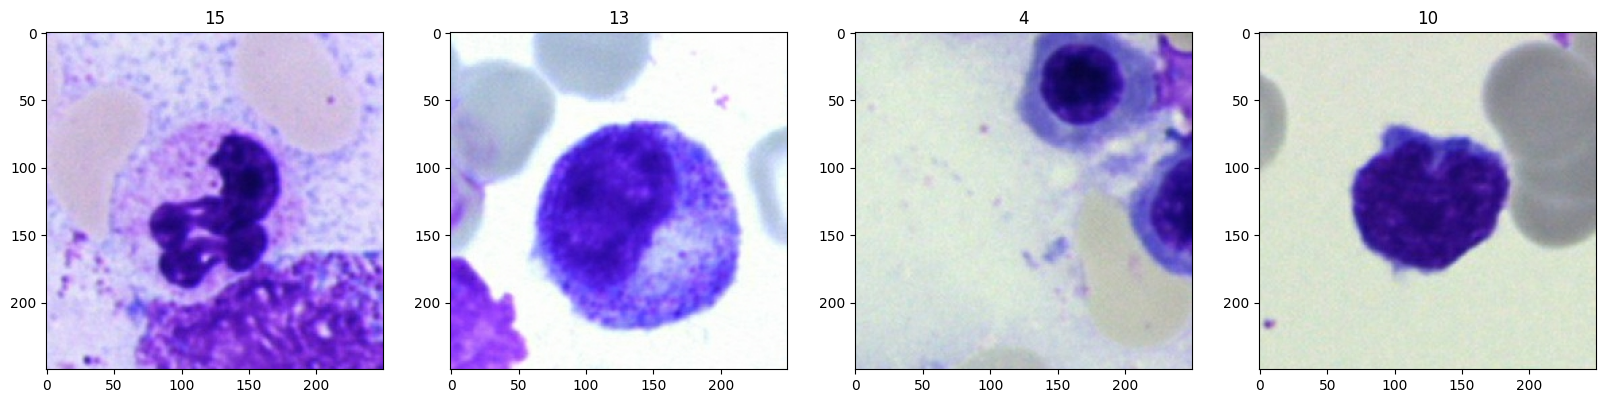

In [4]:
fig, ax = plt.subplots(ncols = 4, figsize=(20, 20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img)
    ax[idx].title.set_text(batch[1][idx])

2.2 Split Data

3. Deep Model

3.1 Build Deep Learning Model

In [5]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, BatchNormalization, Activation

model = Sequential()
# 16 filters, 3x3 size, stride of 1, 
#0
model.add(Conv2D(8, (3, 3), 1, input_shape=(250, 250, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))

#1
model.add(Conv2D(8, (3, 3), 1, padding='same'))  # Adjusted the kernel size
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(4, 4), strides=(4, 4)))

#2
model.add(Conv2D(16, (3, 3), 1, padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))

#3
model.add(Conv2D(16, (3, 3), 1, padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(4, 4), strides=(4, 4)))

#4
model.add(Conv2D(32, (3, 3), 1, padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))

#5
model.add(Conv2D(32, (3, 3), 1, padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(4, 4), strides=(4, 4)))

#6
model.add(Conv2D(64, (3, 3), 1, padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))

#7
model.add(Conv2D(64, (3, 3), 1, padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(3, 3), strides=(3, 3)))

model.add(Flatten())

# Fully connected layers
model.add(Dense(256))
model.add(Activation('relu'))
model.add(Dense(21))
model.add(Activation('softmax'))

In [6]:
# Uses adam optimiser
from tensorflow.keras.optimizers import Adam

model.compile('adam', loss = tf.losses.SparseCategoricalCrossentropy(),metrics = ['accuracy'])

In [7]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 250, 250, 8)       224       
                                                                 
 batch_normalization (BatchN  (None, 250, 250, 8)      32        
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 250, 250, 8)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 250, 250, 8)       584       
                                                                 
 activation_1 (Activation)   (None, 250, 250, 8)       0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 62, 62, 8)        0         
 )                                                      

3.2 Training

In [8]:
logdir = 'logs'
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir = logdir)

In [9]:
import time

t0 = time.time()
hist = model.fit(training_data, epochs = 50, validation_data = val_data, callbacks = [tensorboard_callback], verbose = 2)
t1 = time.time()-t0

print('Training time: ', t1)

Epoch 1/50


2024-01-21 17:00:17.604424: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8901
2024-01-21 17:00:18.179879: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:655] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2024-01-21 17:00:18.205132: I tensorflow/compiler/xla/service/service.cc:169] XLA service 0x55e1937d02b0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-01-21 17:00:18.205159: I tensorflow/compiler/xla/service/service.cc:177]   StreamExecutor device (0): NVIDIA GeForce RTX 3060, Compute Capability 8.6
2024-01-21 17:00:18.210180: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-01-21 17:00:18.342762: I ./tensorflow/compiler/jit/device_compiler.h:180] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the p

3000/3000 - 97s - loss: 1.1486 - accuracy: 0.6379 - val_loss: 1.4862 - val_accuracy: 0.5530 - 97s/epoch - 32ms/step
Epoch 2/50
3000/3000 - 87s - loss: 0.8620 - accuracy: 0.7243 - val_loss: 1.1838 - val_accuracy: 0.6225 - 87s/epoch - 29ms/step
Epoch 3/50
3000/3000 - 87s - loss: 0.7783 - accuracy: 0.7483 - val_loss: 0.8920 - val_accuracy: 0.7155 - 87s/epoch - 29ms/step
Epoch 4/50
3000/3000 - 86s - loss: 0.7231 - accuracy: 0.7658 - val_loss: 0.8144 - val_accuracy: 0.7396 - 86s/epoch - 29ms/step
Epoch 5/50
3000/3000 - 86s - loss: 0.6851 - accuracy: 0.7775 - val_loss: 0.7964 - val_accuracy: 0.7441 - 86s/epoch - 29ms/step
Epoch 6/50
3000/3000 - 86s - loss: 0.6558 - accuracy: 0.7852 - val_loss: 0.8140 - val_accuracy: 0.7375 - 86s/epoch - 29ms/step
Epoch 7/50
3000/3000 - 86s - loss: 0.6303 - accuracy: 0.7932 - val_loss: 0.7833 - val_accuracy: 0.7478 - 86s/epoch - 29ms/step
Epoch 8/50
3000/3000 - 87s - loss: 0.6038 - accuracy: 0.8018 - val_loss: 0.8185 - val_accuracy: 0.7368 - 87s/epoch - 29ms/

3.3 Plot Performance

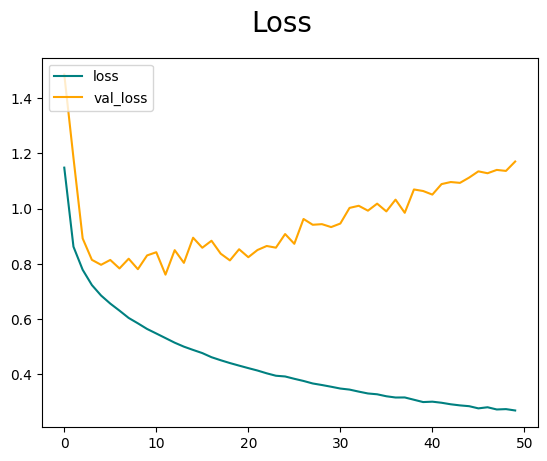

In [10]:
fig = plt.figure()
plt.plot(hist.history['loss'], color = 'teal', label = 'loss')
plt.plot(hist.history['val_loss'], color = 'orange', label = 'val_loss')
fig.suptitle('Loss', fontsize = 20)
plt.legend(loc = "upper left")
plt.show()

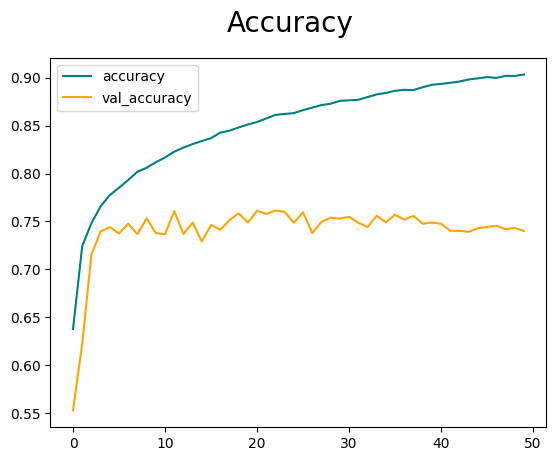

In [11]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color = 'teal', label = 'accuracy')
plt.plot(hist.history['val_accuracy'], color = 'orange', label = 'val_accuracy')
fig.suptitle('Accuracy', fontsize = 20)
plt.legend(loc = "upper left")
plt.show()

In [13]:
import pickle

folder = 'pickle'
inner_foler = 'model'

with open(os.path.join(folder, inner_foler, 'model_pickle'), 'wb') as f:
    pickle.dump(model, f)

In [14]:
with open(os.path.join(folder, inner_foler, 'history_pickle'), 'wb') as f:
    pickle.dump(hist.history, f)

4. Evaluate Performance

4.1 Evaluate

In [15]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [16]:
precision_per_class = [tf.keras.metrics.Precision(class_id=i) for i in range(21)]
recall_per_class = [tf.keras.metrics.Recall(class_id=i) for i in range(21)]
accuracy_per_class = [tf.keras.metrics.BinaryAccuracy(threshold=0.0) for _ in range(21)]

In [17]:
y_true = []
y_pred = []

for batch in val_data.as_numpy_iterator():
    batch_size = len(batch[0])  # Assuming the first element of the batch is the input data
    print(f"Current batch size: {batch_size}")
    image, y = batch
    y_one_hot = tf.one_hot(y, 21)
    yhat = model.predict(image)
    pre.update_state(y_one_hot, yhat)
    re.update_state(y_one_hot, yhat)
    acc.update_state(y_one_hot, yhat)
    
    y_true.extend(np.argmax(y_one_hot, axis = 1))
    y_pred.extend(np.argmax(yhat, axis = 1))
    
    # Had OOM errors previously
    tf.keras.backend.clear_session()

Current batch size: 32
1/1 [==============================] - 0s 165ms/step
Current batch size: 32
1/1 [==============================] - 0s 75ms/step
Current batch size: 32
1/1 [==============================] - 0s 76ms/step
Current batch size: 32
1/1 [==============================] - 0s 76ms/step
Current batch size: 32
1/1 [==============================] - 0s 73ms/step
Current batch size: 32
1/1 [==============================] - 0s 73ms/step
Current batch size: 32
1/1 [==============================] - 0s 73ms/step
Current batch size: 32
1/1 [==============================] - 0s 75ms/step
Current batch size: 32
1/1 [==============================] - 0s 65ms/step
Current batch size: 32
1/1 [==============================] - 0s 64ms/step
Current batch size: 32
1/1 [==============================] - 0s 64ms/step
Current batch size: 32
1/1 [==============================] - 0s 64ms/step
Current batch size: 32
1/1 [==============================] - 0s 63ms/step
Current batch size: 32
1

In [18]:
from sklearn.metrics import classification_report

print("Total")
print(f'Precision{pre.result().numpy()}, Recall:{re.result().numpy()}, Accuracy:{acc.result().numpy()}')

y_true = np.array(y_true)
y_pred = np.array(y_pred)
class_labels = [str(i) for i in range(21)]
class_names = [label_to_class_mapping[label] for label in sorted(label_to_class_mapping.keys())]

# Generate classification report with specified labels
class_report = classification_report(y_true, y_pred, labels=class_labels, target_names=class_names)
print("Classification Report:\n", class_report)

Total
Precision0.7629545331001282, Recall:0.724731981754303, Accuracy:0.9761696457862854
Classification Report:
               precision    recall  f1-score   support

         ABE       0.00      0.00      0.00         1
         ART       0.72      0.83      0.77      2747
         BAS       0.25      0.10      0.14        61
         BLA       0.59      0.71      0.64      1675
         EBO       0.88      0.91      0.90      3834
         EOS       0.87      0.85      0.86       822
         FGC       0.00      0.00      0.00         6
         HAC       0.29      0.21      0.24        57
         KSC       0.00      0.00      0.00         6
         LYI       0.00      0.00      0.00         9
         LYT       0.82      0.82      0.82      3673
         MMZ       0.24      0.21      0.22       427
         MON       0.41      0.42      0.41       564
         MYB       0.51      0.39      0.44       917
         NGB       0.54      0.57      0.55      1394
         NGS       0.8

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


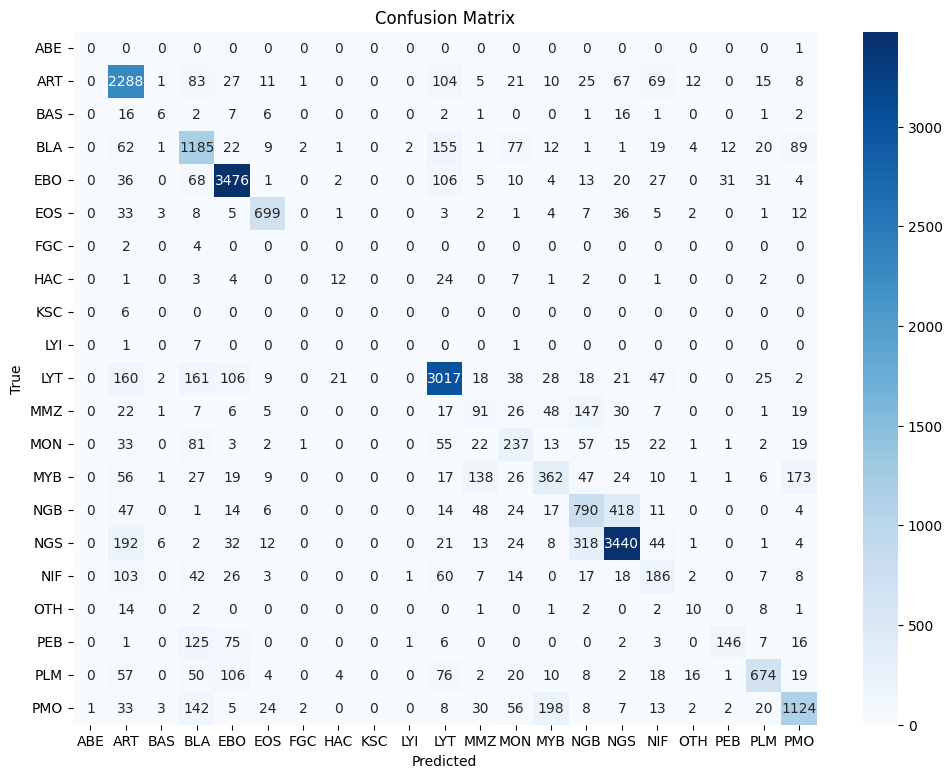

In [19]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

true_labels = np.argmax(y_one_hot, axis=1)
predicted_labels = np.argmax(yhat, axis=1)
conf_matrix = confusion_matrix(y_true, y_pred, labels = list(range(21)))
plt.figure(figsize=(12, 9))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

confusion_data = {
    'conf_matrix': conf_matrix,
    'class_labels': class_names,
}

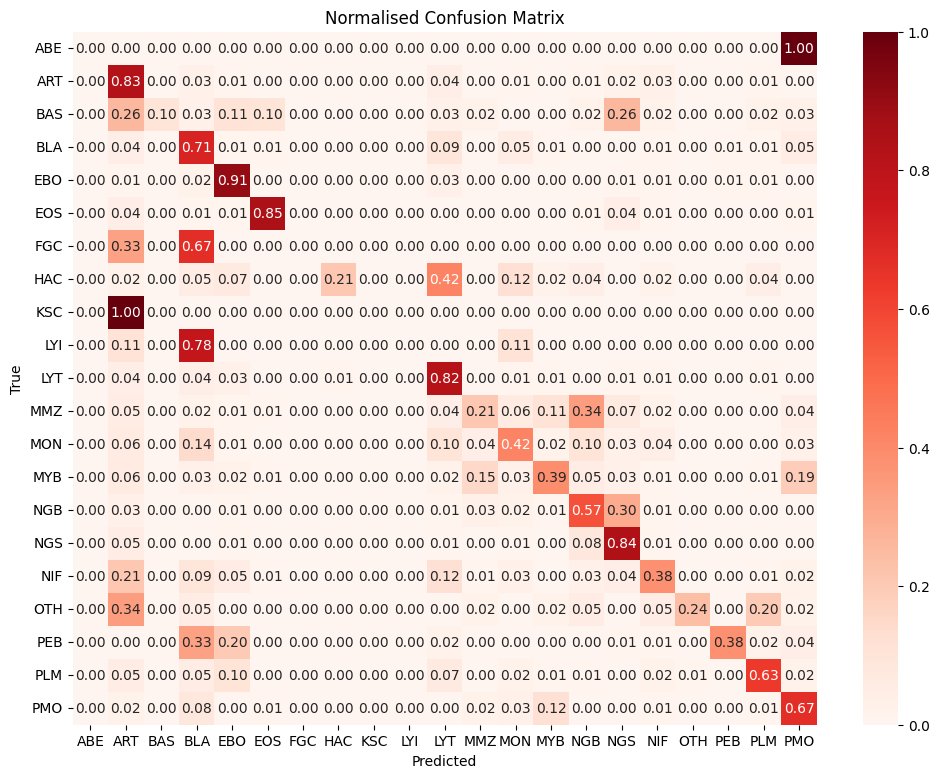

array([1.  , 0.99, 1.  , 1.  , 1.01, 0.98, 1.  , 1.01, 1.  , 1.  , 0.99,
       0.98, 0.99, 1.  , 0.99, 1.01, 1.  , 0.99, 1.01, 0.99, 0.97])

In [20]:
class_totals = np.sum(conf_matrix, axis=1)

normalised_conf_matrix = np.zeros_like(conf_matrix, dtype=float)
for i in range(len(class_totals)):
    if class_totals[i] != 0:
        normalised_conf_matrix[i, :] = np.round(conf_matrix[i, :] / class_totals[i], 2)

# # Plot the normalised confusion matrix with class names as tick labels
plt.figure(figsize=(12, 9))
sns.heatmap(normalised_conf_matrix, annot=True, fmt='.2f', cmap='Reds', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Normalised Confusion Matrix')
plt.show()

totals = np.sum(normalised_conf_matrix, axis=1)

normalised_confusion_data = {
    'normalised_conf_matrix': normalised_conf_matrix,
    'class_labels': class_names,
}

totals

5. Save model & outputs

In [21]:
with open(os.path.join(folder, inner_foler, 'classification_report'), 'wb') as f:
    pickle.dump(class_report, f)
    
with open(os.path.join(folder, inner_foler, 'confusion_data'), 'wb') as f:
    pickle.dump(confusion_data, f)
    
with open(os.path.join(folder, inner_foler, 'normalised_confusion_data'), 'wb') as f:
    pickle.dump(normalised_confusion_data, f)